# Loan Status Prediction

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline


In [2]:
loan_df = pd.read_csv('loan_timing.csv')

In [3]:
loan_df

,days since origination,days from origination to chargeoff
0,109,NaN
1,679,NaN
2,723,NaN
3,509,NaN
4,254,NaN
...,...,...
49995,253,NaN
49996,664,NaN
49997,209,NaN
49998,214,NaN


In [4]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   days since origination              50000 non-null  int64  
 1   days from origination to chargeoff  3305 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 781.4 KB


In [5]:
loan_df.describe()

,days since origination,days from origination to chargeoff
count,50000.000000,3305.000000
mean,365.844760,214.852345
std,210.965114,165.233874
min,0.000000,0.000000
25%,183.000000,76.000000
50%,366.000000,180.000000
75%,549.000000,323.000000
max,730.000000,725.000000


In [6]:
loan_df.isnull().sum()

days since origination                    0
days from origination to chargeoff    46695
dtype: int64

### Partition data set into two: default (charged-off) and active

In [7]:
active = loan_df[loan_df["days from origination to chargeoff"].isnull()]

In [8]:
active

,days since origination,days from origination to chargeoff
0,109,NaN
1,679,NaN
2,723,NaN
3,509,NaN
4,254,NaN
...,...,...
49995,253,NaN
49996,664,NaN
49997,209,NaN
49998,214,NaN


In [9]:
defaulted = loan_df.dropna()
defaulted

,days since origination,days from origination to chargeoff
14,327,78.0
15,400,390.0
16,721,362.0
26,410,48.0
61,649,412.0
...,...,...
49937,661,167.0
49947,520,89.0
49980,356,107.0
49981,280,192.0


In [10]:
defaulted.describe()

,days since origination,days from origination to chargeoff
count,3305.000000,3305.000000
mean,474.198790,214.852345
std,176.942232,165.233874
min,10.000000,0.000000
25%,343.000000,76.000000
50%,501.000000,180.000000
75%,625.000000,323.000000
max,730.000000,725.000000


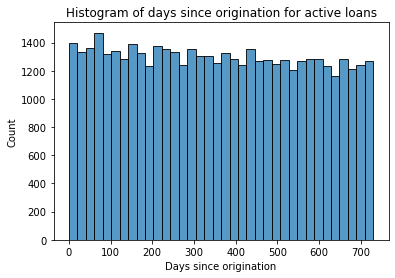

In [11]:
# Histogram of days since origination for active loans
sns.histplot(active["days since origination"])
plt.title("Histogram of days since origination for active loans")
plt.xlabel("Days since origination")
plt.show()

Active loans are uniformly distributed over the days since origination.

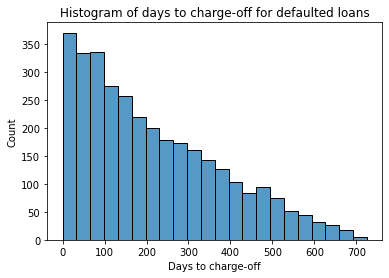

In [12]:
# Histogram of days to charge-off for defaulted loans
sns.histplot(defaulted["days from origination to chargeoff"])
plt.title("Histogram of days to charge-off for defaulted loans")
plt.xlabel("Days to charge-off")
plt.show()

We see that the proportion of loans that charged off decreases with increasing days from origination to charge-off. This also shows that loans with few charge-offs have higher probability of defaulting.

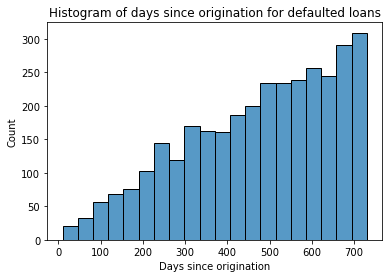

In [13]:
# Histogram of days since origination for defaulted loans
sns.histplot(defaulted["days since origination"])
plt.title("Histogram of days since origination for defaulted loans")
plt.xlabel("Days since origination")
plt.show()

Shows the distribution of defaulted loans over the days since origination to the time when the data was collected.
Defaulted loans cointains a large proportion of loans which are one year and above. These loans are less likely to charge-off compared to loans which are below one year.

Text(0, 0.5, 'days to chargeoff')

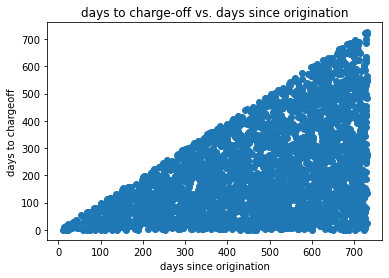

In [14]:
# Plot of days to charge-off vs days since origination for defaulted loans
plt.scatter(defaulted['days since origination'], defaulted['days from origination to chargeoff'])
plt.title('days to charge-off vs. days since origination')
plt.xlabel('days since origination')
plt.ylabel('days to chargeoff')

### Model Selection: Linear Regression

In [15]:
X = defaulted['days since origination']  # assumed as the independent variable (predictor)
Y = defaulted['days from origination to chargeoff']  # assumed as the dependent variable (output)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X.values.reshape((-1, 1)), Y, test_size=0.2, random_state=0)

In [17]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [18]:
model.fit(x_train, y_train)
y_predictions = model.predict(x_test)

In [19]:
model.score(x_test, y_test)  # Accuracy score

0.21740158857152825

In [20]:
from sklearn.metrics import r2_score
r2_score(y_test, y_predictions)

0.21740158857152825

#### Notes
Our dateset has only two features or predictors, and surfers a problem of frequency: 93% of the loans are active, while 7% of the loans are defaulted. Using Linear Regression with defaulted(charged-off) for predicting loans that will have charged off after a period of 3 years produces a model that is biased towards the active loans

## Model Selection:  Survival Analysis

Survival Analysis is a set of statistical approaches used to determine the time it takes for an event of interest to occur. We study the time until some event of interest occurs. For example, in our case the time it takes a loan to be charged-off

Survival analysis focuses on the occurrence of an event of interest. However, there is still a possibility that the event we are interested in does not occur (i.e a loan charge-off deos not occur in a given time perios). Such observations are known as censored observations.

We will use the survival function S(t), the **Kaplan-Meier Estimator**. The survival function is defined as the probability that a subject survives from the time of origin to a specified future time t.

In [21]:
from lifelines import KaplanMeierFitter

In [22]:
df = defaulted

In [23]:
# Create an object of KaplanMeierFitter
kmf = KaplanMeierFitter()

In [24]:
kmf.fit(durations = df['days since origination'], event_observed = df['days from origination to chargeoff'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3305 total observations, 16 right-censored observations>

In [25]:
# Event table
# removed = observed + censored
# censored = days that loan did not charge-off
# obesrved = days a loan was charged off
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,3305,3305
10.0,1,0,1,0,3305
14.0,1,1,0,0,3304
17.0,1,1,0,0,3303
18.0,1,1,0,0,3302
...,...,...,...,...,...
726.0,10,10,0,0,50
727.0,8,8,0,0,40
728.0,12,12,0,0,32


In [26]:
# Predicting the survival probability for an array of value
kmf.predict([0, 10, 14, 23, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 720, 730, 890, 1000, 1095])

0       1.000000
10      1.000000
14      0.999697
23      0.998789
100     0.976371
150     0.949994
200     0.915710
250     0.865950
300     0.810406
350     0.742113
400     0.672910
450     0.593080
500     0.503153
550     0.403494
600     0.302621
650     0.195063
720     0.026973
730     0.000000
890     0.000000
1000    0.000000
1095    0.000000
Name: KM_estimate, dtype: float64

In [27]:
# Survival probability for the whole timeline
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
10.0,1.000000
14.0,0.999697
17.0,0.999395
18.0,0.999092
...,...
726.0,0.012449
727.0,0.009959
728.0,0.006225


Text(0, 0.5, 'Survival Probability')

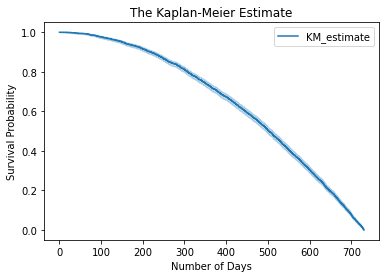

In [28]:
# kmf plot
kmf.plot()
plt.title("The Kaplan-Meier Estimate")
plt.xlabel("Number of Days")
plt.ylabel("Survival Probability")

### Observation

The survival probability for charge-off at timeline 0 is 1. As the timeline increases, the probability of survival of a loan decreases.

In [29]:
kmf.median_survival_time_

502.0

The above provides the number of days where, on average, 50% of the loans were charged off.
So we can say that on average, a loan is charged off after 502 days since origination.

### Restricted Mean Survival Time

The restricted mean is a measure of average survival from time 0 to a specified time point, and may be estimated as the area under the survival curve up to that point.

In [30]:
from lifelines.utils import restricted_mean_survival_time
rmst = restricted_mean_survival_time(kmf, t=1095)  # time limit = 3 years
rmst

475.4897880183705

<AxesSubplot:xlabel='timeline'>

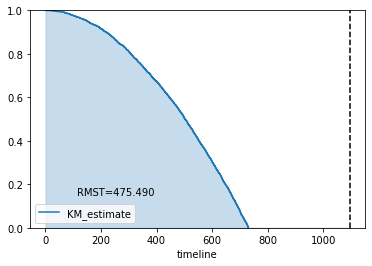

In [31]:
from lifelines.plotting import rmst_plot

time_limit = 1095
rmst_plot(kmf, t=time_limit)

In [32]:
# Probability of loans charged-off
rmst / len(df)

0.1438698299601726

The estimate probability percentage of charged-off loans is 14.39%